In [1]:
# LOAD LIBRARIES
from scipy import stats
import galpy.potential
from galpy.orbit import Orbit
from astropy import units as u
from galpy.potential import LogarithmicHaloPotential
import numpy as np
from galpy.potential import MWPotential2014,PowerSphericalPotential
#from galpy.potential import FerrersPotential,DehnenBarPotential
import matplotlib.pyplot as plt
#import gala.integrate as gi
#import gala.dynamics as gd
#import gala.potential as gp
#from gala.units import galactic
import astropy.units as u
from orbit_functions import *
import pickle
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
from galpy.potential import plotRotcurve
from functools import partial
from scipy.fft import *
from scipy import interpolate, optimize, stats
from astropy.io import fits
from astropy.table import Table, join
import pingouin as pg

plt.rcParams['font.size'] = 12

def load_data_all(xmin, xmax, phi_range):
    df = Table.read('o_galpy/DR3_SH_ruwe14_fidelity05_pioe5_GAL6D.fits', format='fits').to_pandas()
    df['phi'] = df['phi']/360*(2*np.pi)
    df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
    #ind=df['R']<Rmax
    #df=df[ind]    
    x,y,z,VR,Vphi,VZ,R,phi=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi']
    Vphi=Vphi*-1.
    Lz=R*Vphi
    
    indphi = abs(phi) < phi_range
    indphi &= (Lz>xmin)&(Lz<xmax)
    x,y,z,VR,Vphi,VZ,R,Lz,phi=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi]
    return x,y,z,VR,Vphi,VZ,R,Lz,phi

def load_data_ages(xmin, xmax, phi_range, return_oc=False):
    df = Table.read('oc_means_dr3_GAL6D.fits', format='fits').to_pandas()
    df = df[df.nbRV != 0]
    df['phi'] = df['phi']/360*(2*np.pi)
    df['X'],df['Y'],df['Z'],df['VX'],df['VY'],df['VZ']=cyl2cart(df['R'],df['phi'],df['Z'],df['VR'],df['Vphi'],df['VZ'])
    oc = [s.decode('utf-8').split('_')[0] for s in df['oc']]
    x,y,z,VR,Vphi,VZ,R,phi,age=df['X'],df['Y'],df['Z'],df['VR'],df['Vphi'],df['VZ'],df['R'],df['phi'],10**df['ageNN']
    Vphi=Vphi*-1.
    Lz=R*Vphi
    
    indphi = abs(phi) < phi_range
    indphi &= (Lz>xmin)&(Lz<xmax)
    x,y,z,VR,Vphi,VZ,R,Lz,phi,agec=x[indphi],y[indphi],z[indphi],VR[indphi],Vphi[indphi],VZ[indphi],R[indphi],Lz[indphi],phi[indphi],age[indphi]
    lindphi = list(indphi)
    oc = [x for i,x in enumerate(oc) if lindphi[i]]
    if return_oc:
        return x,y,z,VR,Vphi,VZ,R,Lz,phi,age,oc
    return x,y,z,VR,Vphi,VZ,R,Lz,phi,age


def load_data_actions(xmin, xmax, phi_range):
    oo = Table.read('actions_joined.fits', format='fits')

    lst = ('source_id','X','Y','Z','VR','Vphi','VZ','R','phi', 'JR', 'JZ', 'JPhi', 'angleR', 'angleZ', 'anglePhi', 'freqR', 'freqZ', 'freqPhi')
    source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi = (oo[i] for i in lst)
    Lz = -R * Vphi
    phi = -phi
    Vphi = -Vphi

    indphi = ~np.isnan(Jr)
    indphi &= abs(phi) < phi_range
    indphi &= (Lz>xmin)&(Lz<xmax)
    source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = (i[indphi] for i in (source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz))

    return source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz
    

def smooth_bins(x, y, xmin, xmax, binsize, calc_error=False):
    binsLZ=np.arange(xmin,xmax,binsize)
    m,xedge,binnumber=stats.binned_statistic(x, y, statistic='mean', bins=[binsLZ]) 
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    xpol = nx + binsize/2
    means = []
    error = []
    for k in nx:
        rel = y[(k<x) & (x<k+binsize)]
        if len(rel) == 0:
            if len(means) > 0:
                means.append(means[-1])
            else:
                means.append(float('nan'))
            error.append(float('inf'))
        elif len(rel) == 1:
            means.append(np.mean(rel))
            error.append(float('inf'))
        else:
            means.append(np.mean(rel))
            err = np.std(rel, ddof=1)/np.sqrt(len(rel))
            error.append(err)
    ypol = np.array(means)
    error = np.array(error)
    if calc_error:
        return xpol, ypol, error
    return xpol, ypol

/home/hpc/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(



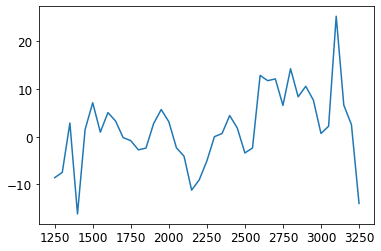

In [88]:
# Lz-VR plot of clusters

XMIN=1250
XMAX=3250
BINSIZE = 50
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
nx, ny, err = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE, calc_error=True)
plt.plot(nx,ny)

[0, 100000000.0, 500000000.0, inf]
681
767
561


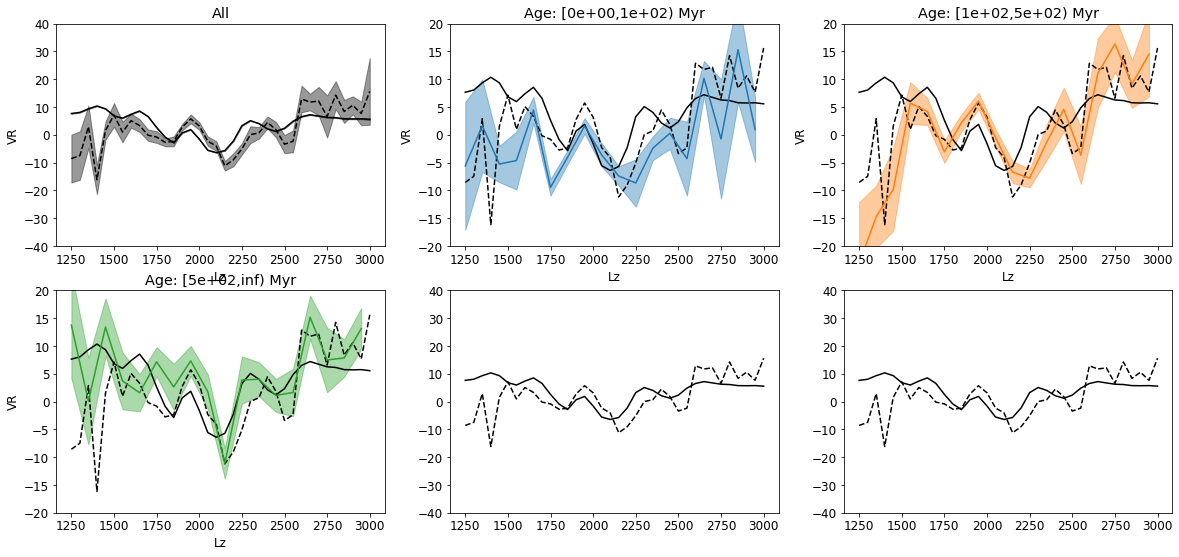

In [5]:
# Lz-VR plot for clusters of different ages, with shaded error.
# The dashed line is the average of all clusters, and the continuous line is the average of all stars

fig, ax = plt.subplots(2,3,figsize=(20,9))

XMIN=1250
XMAX=3000
BINSIZE = 50
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

nx, ny, err = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE, calc_error=True)
for aax in ax:
    for aaax in aax:
        aaax.plot(nx,ny,c='k',ls='--')
        aaax.set_ylim(-40,40)
ax[0][0].fill_between(nx,ny-err,ny+err,color=f'k',alpha=0.4)
ax[0][0].set_title(f'All')
ax[0][0].set_xlabel('Lz')
ax[0][0].set_ylabel('VR')

_,_,_,VR_all,_,_,_,Lz_all,_=load_data_all(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
nx_all, ny_all, err_all = smooth_bins(Lz_all, VR_all, XMIN, XMAX, BINSIZE, calc_error=True)
for aax in ax:
    for aaax in aax:
        aaax.plot(nx_all,ny_all,c='k')
ax[0][0].fill_between(nx_all,ny_all-err_all,ny_all+err_all,color=f'k',alpha=0.4)

bs = 4
#lims = 10*np.arange(6,10.01,1)
lims = [0,100e6,500e6,float('inf')]
print(lims)
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= age) & (age < high)
    nx, ny, err = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 100, calc_error=True)
    print(len(Lz[ind]))
    err[np.isinf(err)] = 100
    rax = ax[(limi+1)//3][(limi+1)%3]
    rax.plot(nx,ny,c=f'C{limi}')
    rax.fill_between(nx,ny-err,ny+err,color=f'C{limi}',alpha=0.4)
    #rax.set_title(f'Age: [{low:.1},{high:.1})')
    rax.set_title(f'Age: [{low/1e6:.1},{high/1e6:.1}) Myr')
    rax.set_xlabel('Lz')
    rax.set_ylabel('VR')
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)
    rax.set_ylim(-20,20)


[0, 50000000.0, 100000000.0, 200000000.0, 500000000.0, inf]
483
198
325
442
561


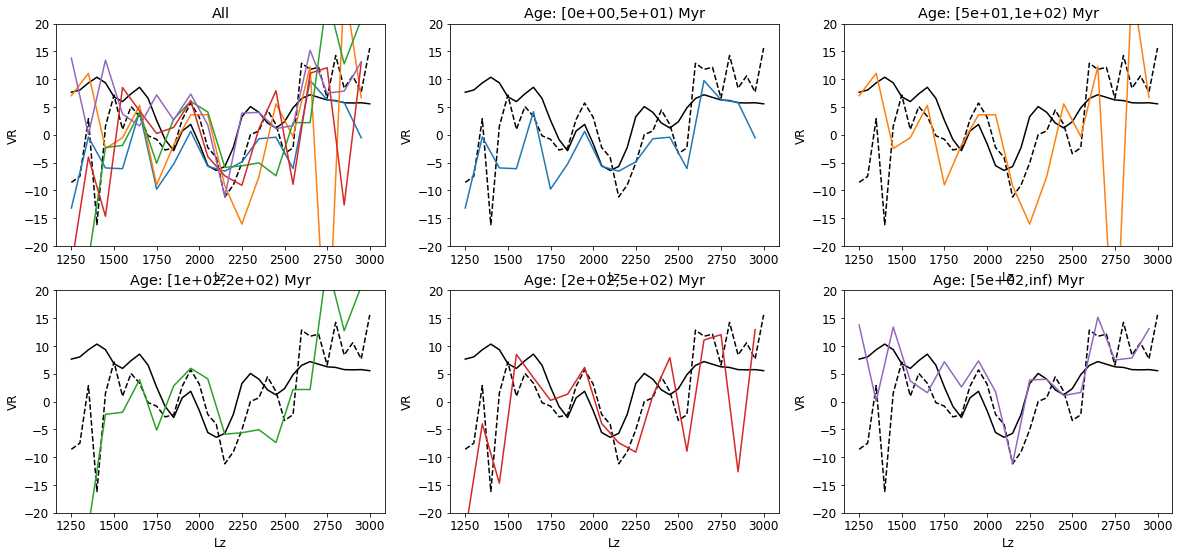

In [116]:
# The same as before but all in the same plot

fig, ax = plt.subplots(2,3,figsize=(20,9))

XMIN=1250
XMAX=3000
BINSIZE = 50
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

nx, ny, err = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE, calc_error=True)
for aax in ax:
    for aaax in aax:
        aaax.plot(nx,ny,c='k',ls='--')
        aaax.set_ylim(-20,20)
ax[0][0].set_title(f'All')
ax[0][0].set_xlabel('Lz')
ax[0][0].set_ylabel('VR')

_,_,_,VR_all,_,_,_,Lz_all,_=load_data_all(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
nx_all, ny_all, err_all = smooth_bins(Lz_all, VR_all, XMIN, XMAX, BINSIZE, calc_error=True)
for aax in ax:
    for aaax in aax:
        aaax.plot(nx_all,ny_all,c='k')

bs = 4
#lims = 10*np.arange(6,10.01,1)
lims = [0,50e6,100e6,200e6,500e6,float('inf')]
print(lims)
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= age) & (age < high)
    nx, ny, err = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, 100, calc_error=True)
    print(len(Lz[ind]))
    err[np.isinf(err)] = 100
    rax = ax[(limi+1)//3][(limi+1)%3]
    ax[0][0].plot(nx,ny,c=f'C{limi}')
    rax.plot(nx,ny,c=f'C{limi}')
    #rax.set_title(f'Age: [{low:.1},{high:.1})')
    rax.set_title(f'Age: [{low/1e6:.1},{high/1e6:.1}) Myr')
    rax.set_xlabel('Lz')
    rax.set_ylabel('VR')
    N = 100000
    f = interpolate.interp1d(nx, ny, kind='linear')
    xpol = np.linspace(nx[0], nx[-1], N)
    ypol = f(xpol)
    xpol = xpol[~np.isnan(ypol)]
    ypol = ypol[~np.isnan(ypol)]
    N = len(ypol)


In [5]:
# Statistical test to check where two curves are significantly different
# For each bin, it performs a chi squared test to see whether the means of each curve in the bin are
# significantly different, and returns the values in the bin.
def test(x1, x2, y1, y2, xmin, xmax, binsize, conf=0.997):
    nx = np.arange(xmin-binsize/2, xmax, binsize)
    diff = []
    error = []
    tstats = []
    pvals = []
    for k in nx:
        rel1 = y1[(k<x1) & (x1<k+binsize)]
        rel2 = y2[(k<x2) & (x2<k+binsize)]
        s1 = np.std(rel1, ddof=1)
        s2 = np.std(rel2, ddof=1)
        try:
            tstat = (np.mean(rel1) - np.mean(rel2)) / np.sqrt(s1**2/len(rel1) + s2**2/len(rel2))
            dof = (s1**2/len(rel1) + s2**2/len(rel2))**2 / (s1**4/len(rel1)**2/(len(rel1)-1) + s2**4/len(rel2)**2/(len(rel2)-1))
        except ZeroDivisionError:
            tstat = 0
            pval = 1
            tstats.append(tstat)
            pvals.append(pval)
            error.append(float('inf'))
            diff.append(np.mean(rel1) - np.mean(rel2))
            continue
        pval = 1-np.abs(stats.t.cdf(tstat, dof)-stats.t.cdf(-tstat, dof))
        tstats.append(tstat)
        pvals.append(pval)
        
        pse = np.sqrt(s1**2/len(rel1) + s2**2/len(rel2))
        error.append(stats.t.ppf(1-(1-conf)/2,dof)*pse)
        diff.append(np.mean(rel1) - np.mean(rel2))
        
        #tstat, pval = stats.ttest_ind(rel1, rel2, equal_var=False)
        #tstats.append(tstat)
        #pvals.append(pval)
    diff, error, tstats, pvals = (np.array(vec) for vec in (diff,error,tstats,pvals))
    return tstats, pvals, diff, error

# Check if two curves before are significantly different, using the results of test()
# It checks if the proportion of bins where both values are different is large enough to say
# that the two curves are different (that is, that the reason the bins are marked as different is not
# a type I error in the chi squared test)
def full_test(pvals, conf):
    pval = stats.binomtest(sum(pvals <= 1-conf),len(pvals),1-conf, alternative='greater').pvalue
    return pval

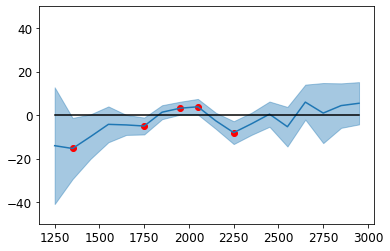

In [15]:
# Performs the statistical test between the curve of clusters and the curve of all stars.
# Plots the difference between two curves (with associated error) and marks the points where
# they are significantly different in red

XMIN=1250
XMAX=3000
BINSIZE = 100
CONF = 0.95
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
_,_,_,VR_all,_,_,_,Lz_all,_=load_data_all(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

tstats, pvals, diff, error = test(Lz, Lz_all, VR, VR_all, XMIN, XMAX, BINSIZE, CONF)
error[np.isinf(error)] = 100
#tstats, pvals, diff, error = test(Lz[ind], Lz, VR[ind], VR, XMIN, XMAX, BINSIZE, CONF)

nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)


limi=0
plt.plot(nx,diff,c=f'C{limi}')
plt.fill_between(nx,diff-error,diff+error,color=f'C{limi}',alpha=0.4)
plt.plot(nx,np.zeros(len(nx)),c=f'k')
plt.ylim(-50,50)

plt.scatter(nx[pvals<1-CONF], diff[pvals<1-CONF], c='r')




0 0.007 True
1 0.0429 True
2 8.09e-05 True
3 0.007 True
4 0.56 False
5 0.56 False


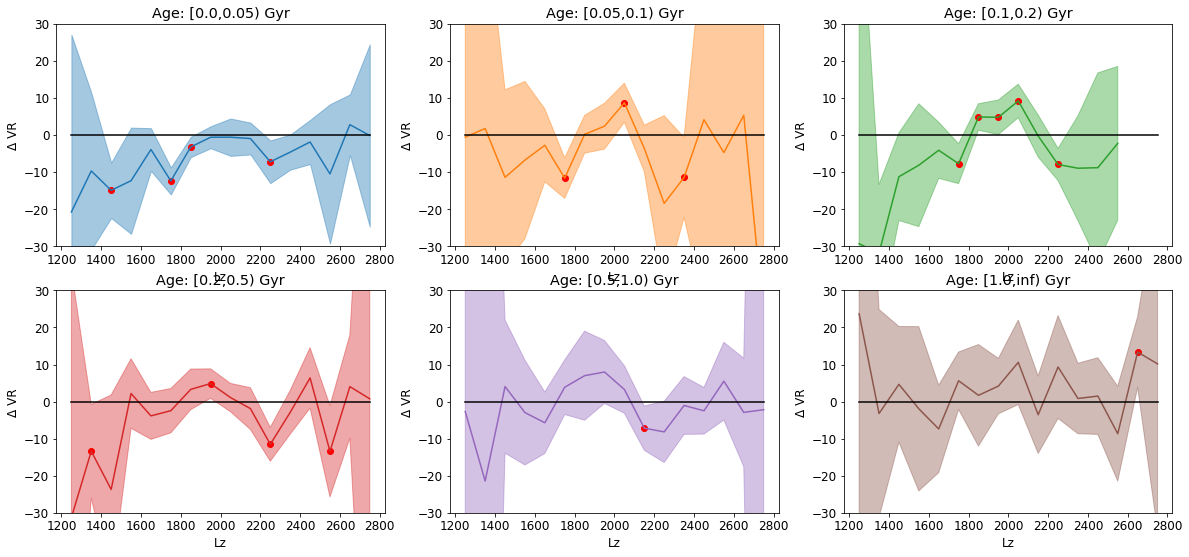

In [8]:
# Performs the test between the average of all stars and the clusters at certain ages.
# Plots the results (same as before) and prints the p-value of full_test and whether the difference is significant

XMIN=1250
XMAX=2750
BINSIZE = 100
CONF = 0.95  # 2*sigma
#CONF = 0.997  # 3*sigma
TCONF = CONF
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
_,_,_,VR_all,_,_,_,Lz_all,_=load_data_all(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

fig, ax = plt.subplots(2,3,figsize=(20,9))


lims = [0,50e6,100e6,200e6,500e6,1000e6,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= age) & (age < high)
    nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)
    tstats, pvals, diff, error = test(Lz[ind], Lz_all, VR[ind], VR_all, XMIN, XMAX, BINSIZE, CONF)
    #tstats, pvals, diff, error = test(Lz[ind], Lz, VR[ind], VR, XMIN, XMAX, BINSIZE, CONF)
    error[np.isinf(error)] = 100
    tpv = full_test(pvals, CONF)
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)
    rax = ax[(limi)//3][(limi)%3]
    rax.plot(nx,diff,c=f'C{limi}')
    rax.fill_between(nx,diff-error,diff+error,color=f'C{limi}',alpha=0.4)
    rax.set_title(f'Age: [{low/1e9},{high/1e9}) Gyr')
    rax.set_xlabel('Lz')
    rax.set_ylabel(r'Δ VR')
    rax.set_ylim(-30,30)
    rax.plot(nx,np.zeros(len(nx)),c=f'k')
    rax.scatter(nx[pvals<1-CONF], diff[pvals<1-CONF], c='r')


8406828 263141
0 8.09e-05 True
1 0.189 False
2 0.007 True
3 0.0429 True
4 0.56 False
5 0.56 False


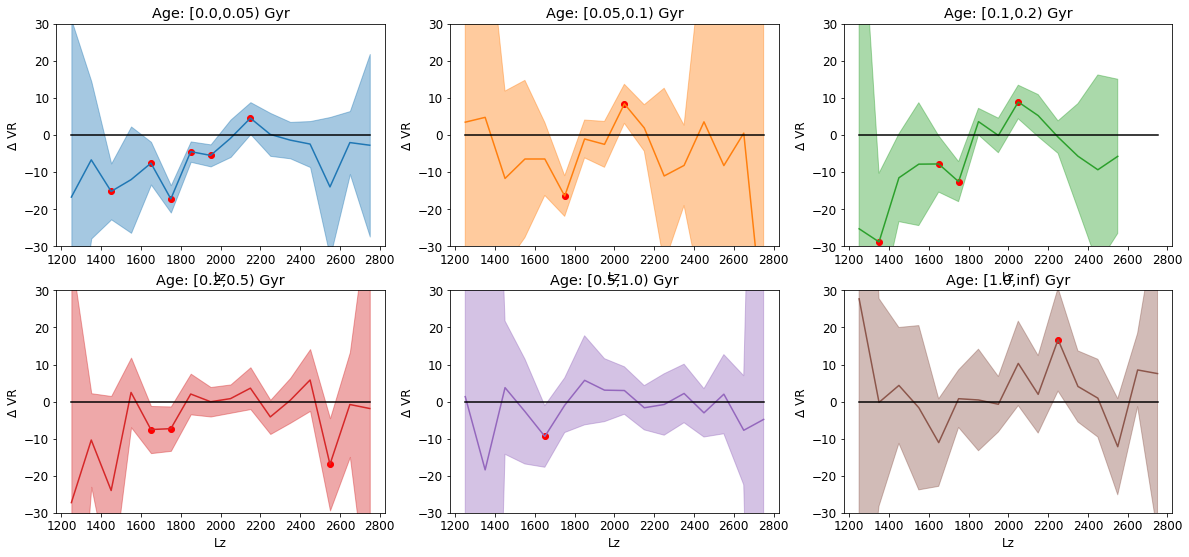

In [13]:
# Same as before, but it uses only the stars with a small Jz instead of all stars

XMIN=1250
XMAX=2750
BINSIZE = 100
CONF = 0.95  # 2*sigma
#CONF = 0.997  # 3*sigma
TCONF = CONF

source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = load_data_actions(XMIN, XMAX, np.pi) 
filt = Jz < 0.1
Lz_j0, VR_j0 = Lz[filt], VR[filt]
print(len(Lz), len(Lz_j0))

x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
fig, ax = plt.subplots(2,3,figsize=(20,9))

lims = [0,50e6,100e6,200e6,500e6,1000e6,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= age) & (age < high)
    nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)
    tstats, pvals, diff, error = test(Lz[ind], Lz_j0, VR[ind], VR_j0, XMIN, XMAX, BINSIZE, CONF)
    error[np.isinf(error)] = 100
    tpv = full_test(pvals, CONF)
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)
    rax = ax[(limi)//3][(limi)%3]
    rax.plot(nx,diff,c=f'C{limi}')
    rax.fill_between(nx,diff-error,diff+error,color=f'C{limi}',alpha=0.4)
    rax.set_title(f'Age: [{low/1e9},{high/1e9}) Gyr')
    rax.set_xlabel('Lz')
    rax.set_ylabel(r'Δ VR')
    rax.set_ylim(-30,30)
    rax.plot(nx,np.zeros(len(nx)),c=f'k')
    rax.scatter(nx[pvals<1-CONF], diff[pvals<1-CONF], c='r')


8406828 263141
0 1.0 False
1 1.62e-08 True
2 1.69e-11 True
3 1.69e-11 True
4 3.68e-13 True
5 3.68e-13 True


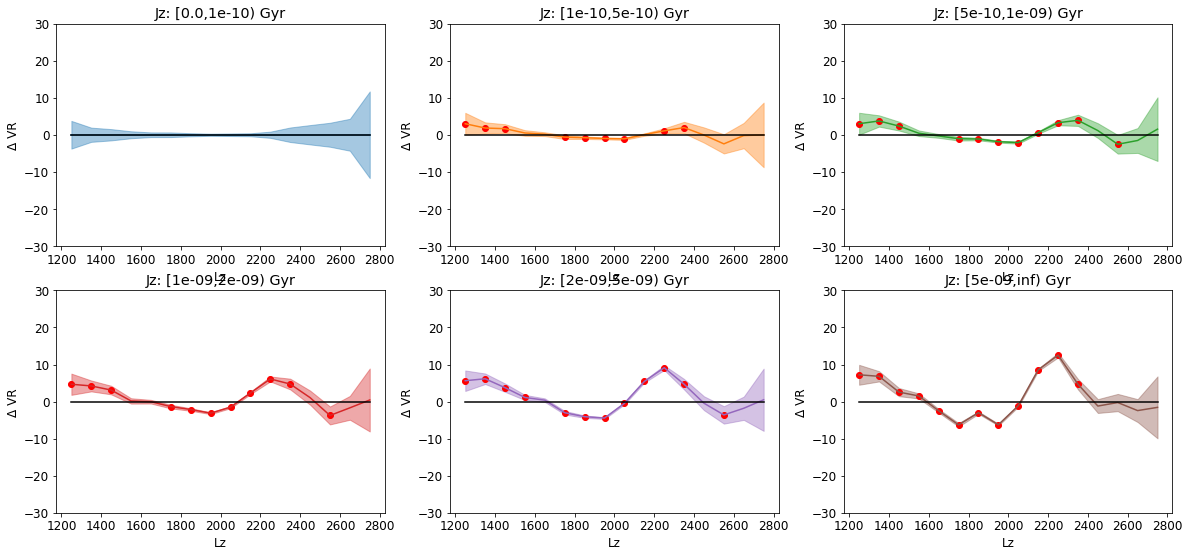

In [11]:
# Same as before, but between the stars of small Jz and the stars of larger Jz

XMIN=1250
XMAX=2750
BINSIZE = 100
CONF = 0.95  # 2*sigma
#CONF = 0.997  # 3*sigma
TCONF = CONF

source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = load_data_actions(XMIN, XMAX, np.pi) 
filt = Jz < 0.1
Lz_j0, VR_j0 = Lz[filt], VR[filt]
print(len(Lz), len(Lz_j0))
fig, ax = plt.subplots(2,3,figsize=(20,9))

lims = [0,0.1,0.5,1,2,5,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= Jz) & (Jz < high)
    nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)
    tstats, pvals, diff, error = test(Lz[ind], Lz_j0, VR[ind], VR_j0, XMIN, XMAX, BINSIZE, CONF)
    error[np.isinf(error)] = 100
    tpv = full_test(pvals, CONF)
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)
    rax = ax[(limi)//3][(limi)%3]
    rax.plot(nx,diff,c=f'C{limi}')
    rax.fill_between(nx,diff-error,diff+error,color=f'C{limi}',alpha=0.4)
    rax.set_title(f'Jz: [{low/1e9},{high/1e9}) Gyr')
    rax.set_xlabel('Lz')
    rax.set_ylabel(r'Δ VR')
    rax.set_ylim(-30,30)
    rax.plot(nx,np.zeros(len(nx)),c=f'k')
    rax.scatter(nx[pvals<1-CONF], diff[pvals<1-CONF], c='r')


In [504]:
# Bootstraping of the test comparing clusters at certain age ranges and the other clusters,
# using bins that start at different values

XMIN=1250
XMAX=2750
BINSIZE = 100
CONF = 0.95  # 2*sigma
#CONF = 0.997  # 3*sigma
#TCONF = CONF
TCONF = 0.997
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

#fig, ax = plt.subplots(2,3,figsize=(20,9))


lims = [0,50e6,100e6,200e6,500e6,1000e6,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= age) & (age < high)
    nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)
    different_points = 0
    total_points = 0
    for bpad in range(BINSIZE):
        tstats, pvals, diff, error = test(Lz[ind], Lz[~ind], VR[ind], VR[~ind], XMIN+bpad, XMAX-BINSIZE+bpad, BINSIZE, CONF)
        total_points += len(pvals)
        different_points += sum(pvals < 1-CONF)
    tpv = stats.binomtest(different_points, total_points, 1-CONF, alternative='greater').pvalue
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)


0 1.38e-168 True
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
1 0.334 False
2 5.94e-12 True
3 0.984 False
4 4.02e-29 True
5 6.14e-113 True


In [505]:
# Bootstraping of the test comparing clusters up to a certain age ranges and older clusters,
# using bins that start at different values

XMIN=1250
XMAX=2750
BINSIZE = 100
CONF = 0.95  # 2*sigma
#CONF = 0.997  # 3*sigma
#TCONF = CONF
TCONF = 0.997
x,y,z,VR,Vphi,VZ,R,Lz,phi,age=load_data_ages(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)

#fig, ax = plt.subplots(2,3,figsize=(20,9))


lims = [0,50e6,100e6,200e6,500e6,1000e6,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (age < high)
    nx, _, _ = smooth_bins(Lz[ind], VR[ind], XMIN, XMAX, BINSIZE, calc_error=True)
    different_points = 0
    total_points = 0
    for bpad in range(BINSIZE):
        tstats, pvals, diff, error = test(Lz[ind], Lz[~ind], VR[ind], VR[~ind], XMIN+bpad, XMAX-BINSIZE+bpad, BINSIZE, CONF)
        total_points += len(pvals)
        different_points += sum(pvals < 1-CONF)
    tpv = stats.binomtest(different_points, total_points, 1-CONF, alternative='greater').pvalue
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)


0 1.38e-168 True
1 1.38e-168 True
2 1.11e-96 True
3 1.25e-94 True
4 6.14e-113 True
5 1.0 False


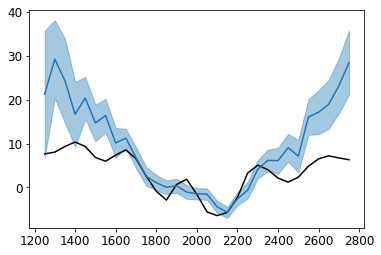

In [112]:
BINSIZE = 50
x,y,z,VR,Vphi,VZ,R,Lz,phi=load_data_all(xmin=XMIN, xmax=XMAX, phi_range=2*np.pi)
nx, ny, err = smooth_bins(Lz, VR, XMIN, XMAX, BINSIZE, calc_error=True)
plt.plot(nx,ny,c='k')
t = Table.read('Astars_SH_ruwe14_fidelity05_pioe5_GAL6D.fits')
LzA = -t['R'] * t['Vphi']
nx, ny, err = smooth_bins(LzA, t['VR'], XMIN, XMAX, BINSIZE, calc_error=True)
plt.plot(nx,ny)
plt.fill_between(nx,ny-2*err,ny+2*err,color=f'C0',alpha=0.4)

['source_id', 'agemyr', 'eagemyr', 'r', 'phi', 'Z', 'vr', 'vphi', 'vZ']
1050
1077


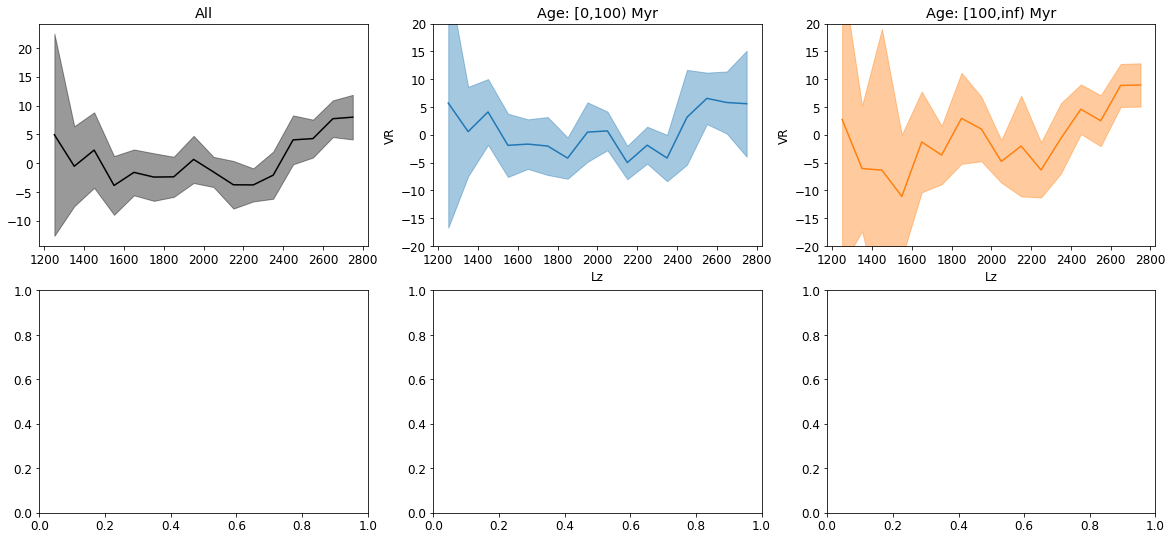

In [47]:
# Lz-VR plots of the Cepheids file

XMIN = 1250
XMAX = 2750
BINSIZE = 100

t = Table.read('cepheidsPAU_6d.fits')
print(t.keys())
Lz = t['vphi'] * t['r']
nx, ny, err = smooth_bins(Lz, t['vr'], XMIN, XMAX, BINSIZE, calc_error=True)
fig, ax = plt.subplots(2,3,figsize=(20,9))
ax[0][0].plot(nx,ny,c='k')
ax[0][0].fill_between(nx,ny-2*err,ny+2*err,color=f'k',alpha=0.4)
ax[0][0].set_title('All')

lims = [0,100,float('inf')]
#lims = [0,100e6,1e12]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= t['agemyr']) & (t['agemyr'] < high)
    print(sum(ind))
    nx, ny, err = smooth_bins(Lz[ind], t['vr'][ind], XMIN, XMAX, BINSIZE, calc_error=True)
    rax = ax[(limi+1)//3][(limi+1)%3]
    rax.plot(nx,ny,c=f'C{limi}')
    rax.fill_between(nx,ny-2*err,ny+2*err,color=f'C{limi}',alpha=0.4)
    rax.set_title(f'Age: [{low},{high}) Myr')
    rax.set_xlabel('Lz')
    rax.set_ylabel(r'VR')
    rax.set_ylim(-20,20)

8406828 263141
['source_id', 'agemyr', 'eagemyr', 'r', 'phi', 'Z', 'vr', 'vphi', 'vZ']
0 5.98e-06 True
1 0.007 True


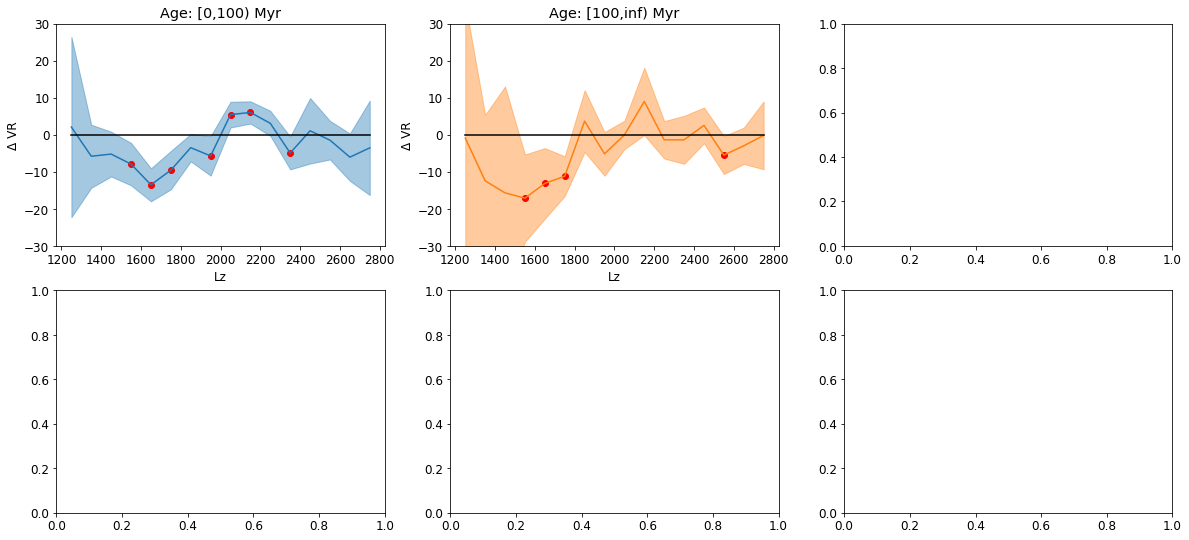

In [52]:
# The same test but with the Cepheids file, compared to all stars

XMIN = 1250
XMAX = 2750
BINSIZE = 100

source_id,x,y,z,VR,Vphi,VZ,R,phi,Jr,Jz,Jphi,angleR,angleZ,anglePhi,freqR,freqZ,freqPhi,Lz = load_data_actions(XMIN, XMAX, np.pi) 
filt = Jz < 0.1
Lz_j0, VR_j0 = Lz[filt], VR[filt]
print(len(Lz), len(Lz_j0))
fig, ax = plt.subplots(2,3,figsize=(20,9))

t = Table.read('cepheidsPAU_6d.fits')
print(t.keys())
Lz = t['vphi'] * t['r']
    
lims = [0,100,float('inf')]
for limi, low, high in zip(range(len(lims)), lims[:-1],lims[1:]):
    ind = (low <= t['agemyr']) & (t['agemyr'] < high)
    nx, _, _ = smooth_bins(Lz[ind], t['vr'][ind], XMIN, XMAX, BINSIZE, calc_error=True)
    tstats, pvals, diff, error = test(Lz[ind], Lz_j0, t['vr'][ind], VR_j0, XMIN, XMAX, BINSIZE, CONF)
    error[np.isinf(error)] = 100
    tpv = full_test(pvals, CONF)
    print(limi, f"{tpv:.3}", tpv < 1-TCONF)
    rax = ax[(limi)//3][(limi)%3]
    rax.plot(nx,diff,c=f'C{limi}')
    rax.fill_between(nx,diff-error,diff+error,color=f'C{limi}',alpha=0.4)
    rax.set_title(f'Age: [{low},{high}) Myr')
    rax.set_xlabel('Lz')
    rax.set_ylabel(r'Δ VR')
    rax.set_ylim(-30,30)
    rax.plot(nx,np.zeros(len(nx)),c=f'k')
    rax.scatter(nx[pvals<1-CONF], diff[pvals<1-CONF], c='r')
